# Amazon Alexa Review - Sentiment Analysis


Analyzing the Amazon Alexa dataset and building classification models to predict if the sentiment of a given input sentence is positive or negative.

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from wordcloud import WordCloud
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import pickle
import re


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/nfe1cob/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/nfe1cob/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Exploratory Data Analysis

In [10]:
# Load the data

data = pd.read_csv('Data/amazon_alexa.tsv',delimiter='\t')

data.shape

(3150, 5)

In [11]:
data.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [12]:
data.columns

Index(['rating', 'date', 'variation', 'verified_reviews', 'feedback'], dtype='object')

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150 entries, 0 to 3149
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   rating            3150 non-null   int64 
 1   date              3150 non-null   object
 2   variation         3150 non-null   object
 3   verified_reviews  3149 non-null   object
 4   feedback          3150 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 123.2+ KB


In [14]:
data.describe()

,rating,feedback
count,3150.000000,3150.000000
mean,4.463175,0.918413
std,1.068506,0.273778
min,1.000000,0.000000
25%,4.000000,1.000000
50%,5.000000,1.000000
75%,5.000000,1.000000
max,5.000000,1.000000


## In data analysis things we need to do
1.Missing values
2.Explore about the numeric variables
3.Explore about catgorical variables
4.Finding relationship between features

In [15]:
#Summ of null values in each columns
data.isnull().sum()

rating              0
date                0
variation           0
verified_reviews    1
feedback            0
dtype: int64

In [16]:
#GETTing the record of 'verified_reviws' that is null
data[data['verified_reviews'].isna() == True]

,rating,date,variation,verified_reviews,feedback
473,2,29-Jun-18,White,NaN,0


In [17]:
#dropping the null records
data.dropna(inplace=True)

In [18]:
#Shape od dataset after droping
data.shape

(3149, 5)

In [19]:
#Creating a new column 'length' that will contain the length of the string in 'verified_reviews' column
data['length'] = data['verified_reviews'].apply(len)

In [20]:
data.head()

,rating,date,variation,verified_reviews,feedback,length
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,13
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,9
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1,195
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1,172
4,5,31-Jul-18,Charcoal Fabric,Music,1,5


In [21]:
#Randomly check for 10Th record

print(f"'verified review' column value: {data.iloc[10]['verified_reviews']}")
print(f"length of the review: {len(data.iloc[10]['verified_reviews'])}")
print(f"length fro the colum 'length': {data.iloc[10]['length']}")

'verified review' column value: I sent it to my 85 year old Dad, and he talks to it constantly.
length of the review: 63
length fro the colum 'length': 63


In [22]:
data.dtypes

rating               int64
date                object
variation           object
verified_reviews    object
feedback             int64
length               int64
dtype: object

## Analysing the 'rating' column

In [23]:
#distint values count for each ratings 

data['rating'].value_counts()

rating
5    2286
4     455
1     161
3     152
2      95
Name: count, dtype: int64

#### Observation

most of the ratings belongs to '5"

so we take "5" and "4" and "3" as positive reviews and "1 and 2" as negative .
is there are many rating in "3" we could take that as neutral sinmce the data is very less moving those into positive

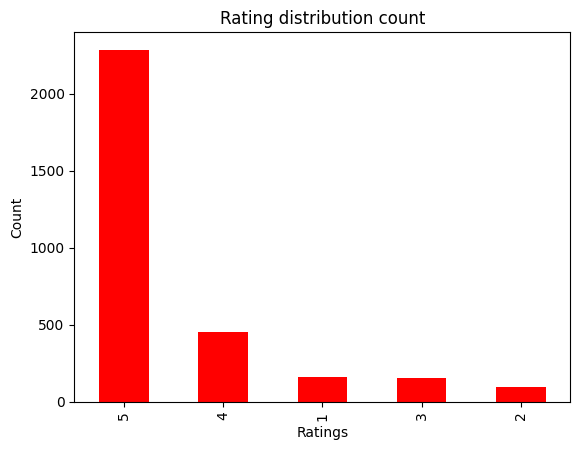

In [24]:
#Bar plot to visualize the total counts of each rating

data['rating'].value_counts().plot.bar(color='red')
plt.title('Rating distribution count')
plt.xlabel('Ratings')
plt.ylabel('Count')
plt.show()

In [25]:
#Finding the percentage distribution of each rating - we'll divide the number of records

pecent_rating = round(data['rating'].value_counts()/data.shape[0]*100,2).to_dict()

In [26]:
pecent_rating

{5: 72.59, 4: 14.45, 1: 5.11, 3: 4.83, 2: 3.02}

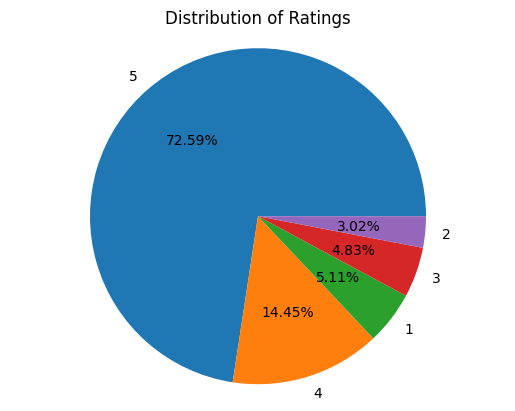

In [27]:
plt.pie(pecent_rating.values(),labels=pecent_rating.keys(),autopct='%1.2f%%',radius=2)

# Adding a title to the pie chart
plt.title('Distribution of Ratings')

# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')
# Save the plot as a PNG file
plt.savefig('pie_chart.png')

# Show plot (optional)
plt.show()

## Analyzing 'feedback' column
This column refers to the feedback of the verified review

In [28]:
#Distinct values of 'feedback' and its count 
data['feedback'].value_counts()

feedback
1    2893
0     256
Name: count, dtype: int64

In [29]:
#Extracting the 'verified_reviews' and rating value for one record with feedback = 0
feedback_0 = data[data['feedback'] == 0].iloc[0]  # Get the first row where 'feedback' is 0
verified_reviews = feedback_0['verified_reviews']
rating = feedback_0['rating']

print(f" Rating: {rating}")
print(f"Verified Reviews: {verified_reviews}")


 Rating: 2
Verified Reviews: It's like Siri, in fact, Siri answers more accurately then Alexa.  I don't see a real need for it in my household, though it was a good bargain on prime day deals.


In [30]:
#Extracting the 'verified_reviews' value for one record with feedback = 1
feedback_1 = data[data['feedback'] == 1].iloc[0]  # Get the first row where 'feedback' is 0
verified_reviews = feedback_1['verified_reviews']
rating = feedback_1['rating']

print(f" Rating: {rating}")
print(f"Verified Reviews: {verified_reviews}")

 Rating: 5
Verified Reviews: Love my Echo!


### Feedback refers to postive and neagtive feedback of customers

the sume of the rating 5,4,3 == count of positive feedback

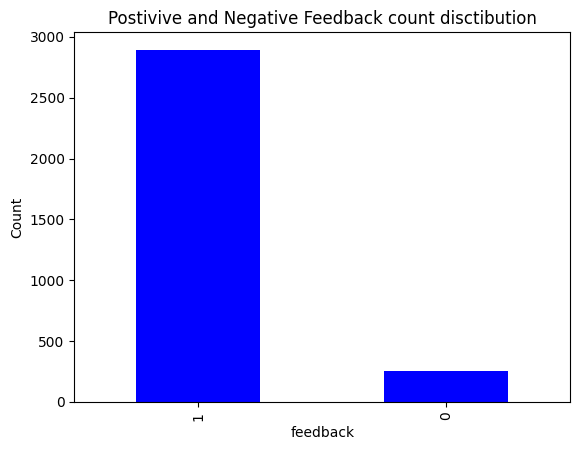

In [31]:
#Bar plot to visualize the total counts of each rating

data['feedback'].value_counts().plot.bar(color='blue')
plt.title('Postivive and Negative Feedback count disctibution')
plt.xlabel('feedback')
plt.ylabel('Count')
plt.show()

In [32]:
#Finding the percentage distribution of each feedback - we'll divide the number of record
feedback_percent =  round(data['feedback'].value_counts()/data.shape[0]*100,2).to_dict()

In [33]:
feedback_percent

{1: 91.87, 0: 8.13}

#### Feedback distribution

91.87% reviews are positive
8.13% reviews are negative

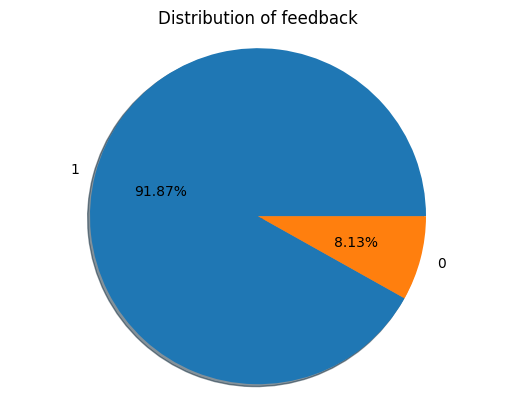

In [34]:
plt.pie(feedback_percent.values(),labels=feedback_percent.keys(),autopct='%1.2f%%',radius=2,shadow=True)

# Adding a title to the pie chart
plt.title('Distribution of feedback')

# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')
# Save the plot as a PNG file
plt.savefig('pie_chart.png')

# Show plot (optional)
plt.show()

In [35]:
#feedback_0
data[data['feedback'] == 0]['rating'].value_counts()

rating
1    161
2     95
Name: count, dtype: int64

In [36]:
#feedback_1
data[data['feedback'] == 1]['rating'].value_counts()

rating
5    2286
4     455
3     152
Name: count, dtype: int64

#### OBSERVATION :

If rating of a reviewer is 1 0r 2 --> feedback is 0 ( negative ) <br>
if rating of a reviewer is 3,4 and 5 --> feedback is 1 ( positive ) <br>


## Analysing 'variation' column

In [37]:
#Distinct values of 'variation' and its count 

data['variation'].value_counts()

variation
Black  Dot                      516
Charcoal Fabric                 430
Configuration: Fire TV Stick    350
Black  Plus                     270
Black  Show                     265
Black                           261
Black  Spot                     241
White  Dot                      184
Heather Gray Fabric             157
White  Spot                     109
Sandstone Fabric                 90
White                            90
White  Show                      85
White  Plus                      78
Oak Finish                       14
Walnut Finish                     9
Name: count, dtype: int64

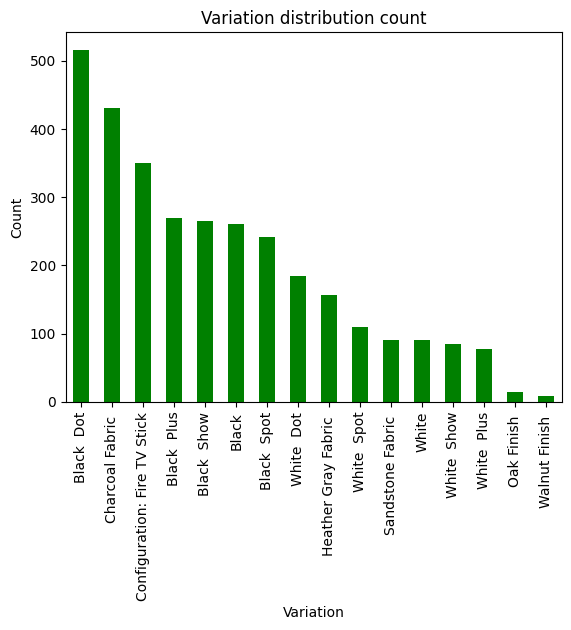

In [38]:
#Bar graph to visualize the total counts of each variation

data['variation'].value_counts().plot.bar(color='green')
plt.title('Variation distribution count')
plt.xlabel('Variation')
plt.ylabel('Count')
plt.show()

In [39]:
#Finding the percentage distribution of each variation - we'll divide the number of records for each variation by total number of records

round(data['variation'].value_counts()/data.shape[0]*100,2)


variation
Black  Dot                      16.39
Charcoal Fabric                 13.66
Configuration: Fire TV Stick    11.11
Black  Plus                      8.57
Black  Show                      8.42
Black                            8.29
Black  Spot                      7.65
White  Dot                       5.84
Heather Gray Fabric              4.99
White  Spot                      3.46
Sandstone Fabric                 2.86
White                            2.86
White  Show                      2.70
White  Plus                      2.48
Oak Finish                       0.44
Walnut Finish                    0.29
Name: count, dtype: float64

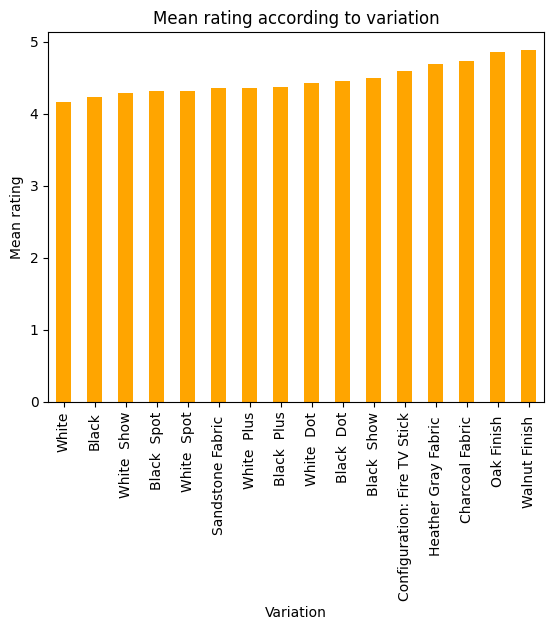

In [40]:
# variation rating mean value

data.groupby('variation')['rating'].mean().sort_values().plot.bar(color="orange")
plt.title("Mean rating according to variation")
plt.xlabel('Variation')
plt.ylabel('Mean rating')
plt.show()

## Analyzing 'verified_reviews' column
This column contains the textual review given by the user for a variation for the product.

In [41]:
data['length'].describe()

count    3149.000000
mean      132.090187
std       182.114569
min         1.000000
25%        30.000000
50%        74.000000
75%       165.000000
max      2851.000000
Name: length, dtype: float64

##### Length analysis for full dataset

[Text(0.5, 1.0, 'Distribution of length of review ')]

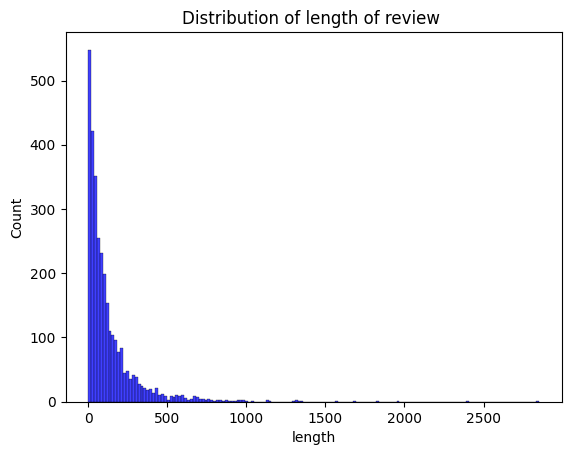

In [42]:
data['length'].count()
sns.histplot(data['length'],color='blue').set(title='Distribution of length of review ')

##### Length analysis when feedback is 0 (negative)

shorter length feedback are more negative
legth from 0 to 750 comes under negative 

[Text(0.5, 1.0, 'Distribution of length of review if feedback = 0')]

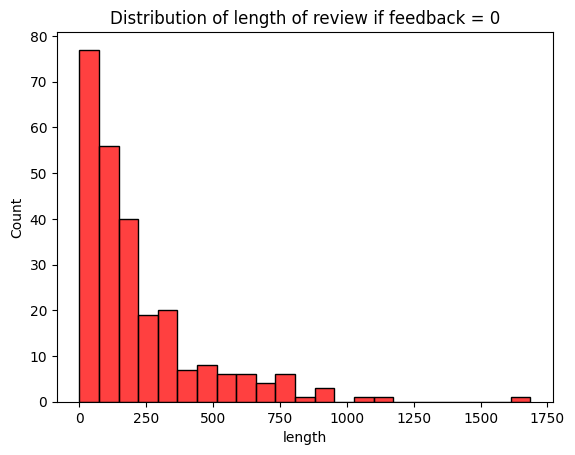

In [43]:
sns.histplot(data[data['feedback'] == 0]['length'],color='red').set(title='Distribution of length of review if feedback = 0')

##### Length analysis when feedback is 1 (positive)

shorter length feedback are more positive
mostly they are < 500 are positive

[Text(0.5, 1.0, 'Distribution of length of review if feedback = 1')]

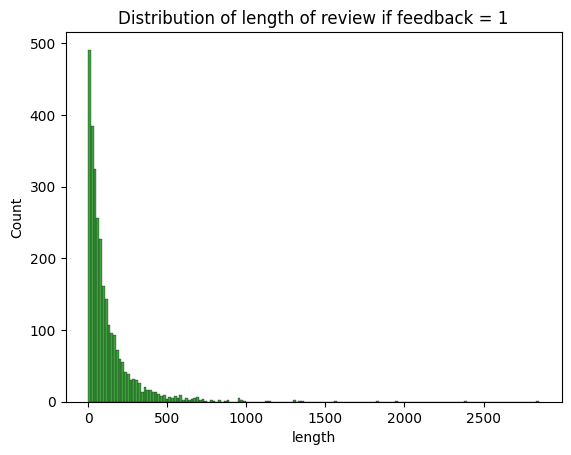

In [44]:
sns.histplot(data[data['feedback'] == 1]['length'],color='green').set(title='Distribution of length of review if feedback = 1')

##### Lengthwise mean rating

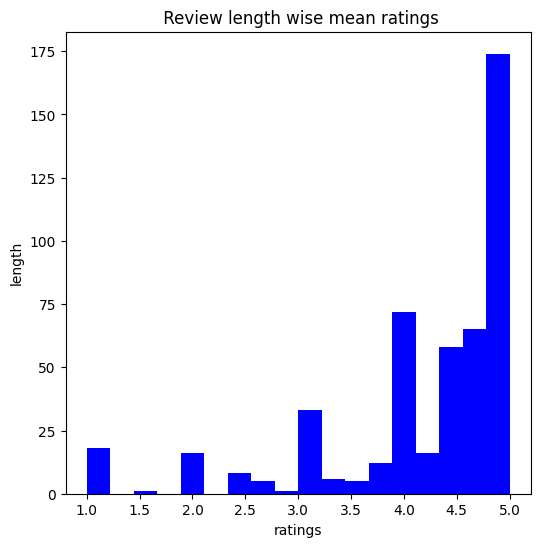

In [45]:
data.groupby('length')['rating'].mean().plot.hist(color = 'blue', figsize=(6, 6), bins = 18)
plt.title(" Review length wise mean ratings")
plt.xlabel('ratings')
plt.ylabel('length')
plt.show()

lengthy feedbacks have more ratings

## CountVectorizer and fit_transform Explanation

This document explains how to use `CountVectorizer` from the `scikit-learn` library to process text data.

- ***CountVectorizer***: This is a class in scikit-learn used for converting a collection of text documents to a matrix of token counts.

### This method does two things:

- **fit**: Learns the vocabulary from the `data.verified_reviews`. It finds all the unique words in the reviews, excluding the stop words.
- **transform**: Transforms the text data into a matrix of token counts. Each row in this matrix corresponds to a review, and each column corresponds to a word in the vocabulary. The values in the matrix indicate the count of each word in each review.


In [46]:
#all the tokens exculding the stopwords
cv = CountVectorizer(stop_words='english')
words = cv.fit_transform(data.verified_reviews)

In [47]:
# Combine all reviews
reviews = " ".join([review for review in data['verified_reviews']])

In [48]:
# Initialize wordcloud object
wc = WordCloud(background_color='white', max_words=50)

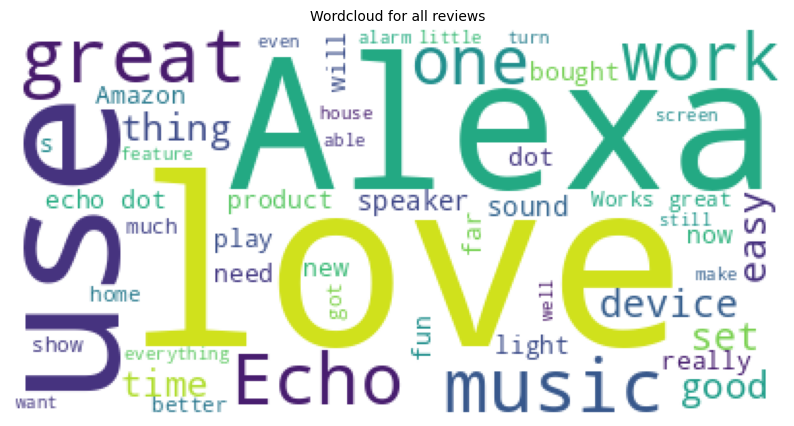

In [49]:
# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(reviews))
plt.title('Wordcloud for all reviews', fontsize=10)
plt.axis('off')
plt.show()

##### Lets find the unique words in each feedback category

In [50]:

# Combine all reviews for each feedback category and splitting them into individual words

#splitting the negative and posiitve reviews

negative_reviews = "".join(data[data['feedback']==0]['verified_reviews'])
negative_reviews = negative_reviews.lower().split()


positive_reviews = " ".join([review for review in data[data['feedback'] == 1]['verified_reviews']])
positive_reviews = positive_reviews.lower().split()


In [51]:
#Finding words from reviews which are present in that feedback category only
#slect unique words that present only in negative and positive

unique_negative = [x for x in negative_reviews if x not in positive_reviews]
unique_negative = " ".join(unique_negative)


unique_positive = [x for x in positive_reviews if x not in negative_reviews]
unique_positive = " ".join(unique_positive)




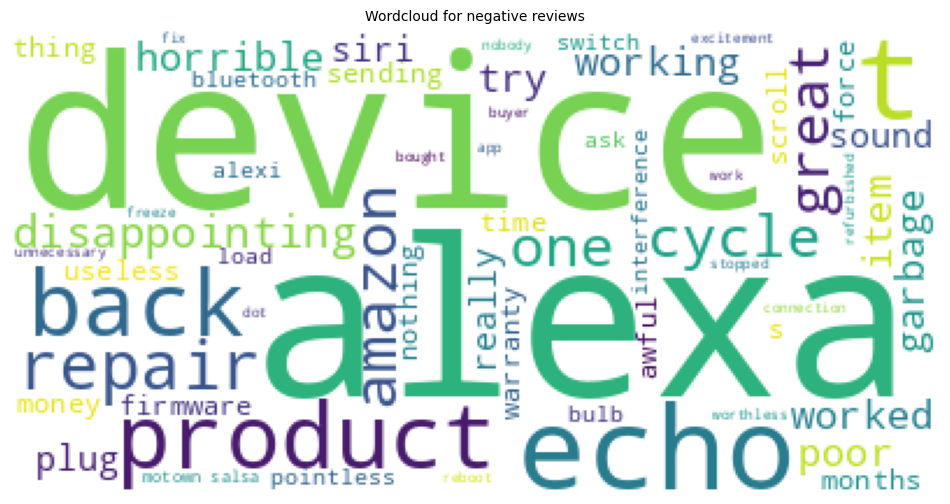

In [52]:
wc = WordCloud(background_color='white', max_words=60)

# Generate and plot wordcloud
plt.figure(figsize=(12,12))
plt.imshow(wc.generate(unique_negative))
plt.title('Wordcloud for negative reviews', fontsize=10)
plt.axis('off')
plt.show()

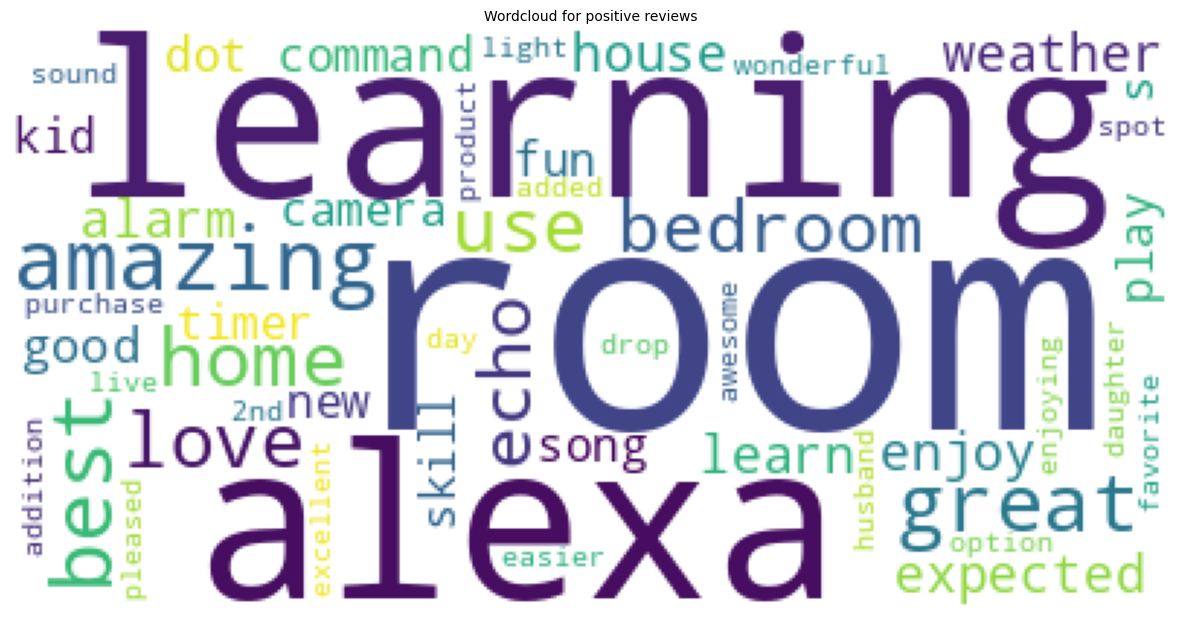

In [53]:

wc = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(15,15))
plt.imshow(wc.generate(unique_positive))
plt.title('Wordcloud for positive reviews', fontsize=10)
plt.axis('off')
plt.show()

## Preprocessing and Modelling
<br>
To build the corpus from the 'verified_reviews' we perform the following:

1.Replace any non alphabet characters with a space <br>
2.Covert to lower case and split into words <br>
3.Iterate over the individual words and if it is not a stopword then add the stemmed form of the word to the corpus

In [62]:
#  error occurs because the corpus contains very few distinct words 
# after applying the stop words and tokenization, which may not be sufficient
# for CountVectorizer to build a meaningful vocabulary


corpus=[]
lemmatizer = WordNetLemmatizer()

for i in range(0,data.shape[0]):
    review = re.sub('[^a-zA-Z]', ' ', data.iloc[i]['verified_reviews'])
    review = review.lower().split()
    review = [lemmatizer.lemmatize(word) for word in review if not word in STOPWORDS]
    review = ' '.join(review)
    corpus.append(review)

In [63]:
corpus

['love echo',
 'loved',
 'sometimes playing game answer question correctly alexa say got wrong answer like able turn light away home',
 'lot fun thing yr old learns dinosaur control light play game like category nice sound playing music well',
 'music',
 'received echo gift needed another bluetooth something play music easily accessible found smart speaker wait see else',
 'without cellphone cannot use many feature ipad see use great alarm u r almost deaf hear alarm bedroom living room reason enough keep fun ask random question hear response seem smartbon politics yet',
 'think th one purchased working getting one every room house really like feature offer specifily playing music echo controlling light throughout house',
 'look great',
 'love listened song heard since childhood get news weather information great',
 'sent year old dad talk constantly',
 'love learning knew thing eveyday still figuring everything work far easy use understand make laugh time',
 'purchased mother knee prob

In [59]:
# corpus=[]
# stemmer = PorterStemmer()

# for i in range(0,data.shape[0]):
#     review = re.sub('[^a-zA-Z]', ' ', data.iloc[i]['verified_reviews'])
#     review = review.lower().split()
#     review = [ ]


# Using Count Vectorizer to create bag of words


#### Using Count Vectorizer to create bag of words ( converting the tokens into vectore format for the model to understand)

 the max_features parameter is used to limit the number of features (unique words or tokens) included in the resulting vocabulary.

In [70]:
cv = CountVectorizer(max_features=2500)

# #Storing independent and dependent variables in X and y
X = cv.fit_transform(corpus).toarray()
Y = data['feedback'].values

In [72]:
#Saving the Count Vectorizer
pickle.dump(cv, open('Models/countVectorizer.pkl', 'wb'))

In [74]:

X.shape

(3149, 2500)

In [73]:
Y.shape

(3149,)

In [80]:
X[145]

array([0, 1, 0, ..., 0, 0, 0])

In [81]:
Y[67]

1

#### 3149: This is the number of documents (reviews) in your corpus
#### 2500: This is the number of features (unique words/tokens) in the vocabulary,  limited by the max_features=2500 parameter





Splitting data into train and test set with 30% data with testing.

In [75]:
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.3,random_state= 5)

print(f"X train: {X_train.shape}")
print(f"y train: {y_train.shape}")
print(f"X test: {X_test.shape}")
print(f"y test: {y_test.shape}")

X train: (2204, 2500)
y train: (2204,)
X test: (945, 2500)
y test: (945,)


By setting random state to a specific number, the data split will be the same each time you run the code. Without it, each run may result in a different split, making it harder to compare results or debug issues.

In [82]:

scaler = MinMaxScaler()

X_train_scl = scaler.fit_transform(X_train)
X_test_scl = scaler.transform(X_test)

In [83]:
#Saving the scaler model
pickle.dump(scaler, open('Models/scaler.pkl', 'wb'))

## Random Forest

In [84]:
#Fitting scaled X_train and y_train on Random Forest Classifier
model_rf = RandomForestClassifier()
model_rf.fit(X_train_scl, y_train)

RandomForestClassifier()

In [85]:
#Accuracy of the model on training and testing data
 
print("Training Accuracy :", model_rf.score(X_train_scl, y_train))
print("Testing Accuracy :", model_rf.score(X_test_scl, y_test))

Training Accuracy : 0.9941016333938294
Testing Accuracy : 0.9428571428571428


In [86]:
#Predicting on the test set
y_preds = model_rf.predict(X_test_scl)

In [91]:
accuracy = accuracy_score(y_test, y_preds)
print(f"Accuracy on test set: {accuracy:.2f}")


Accuracy on test set: 0.94


In [87]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_preds)

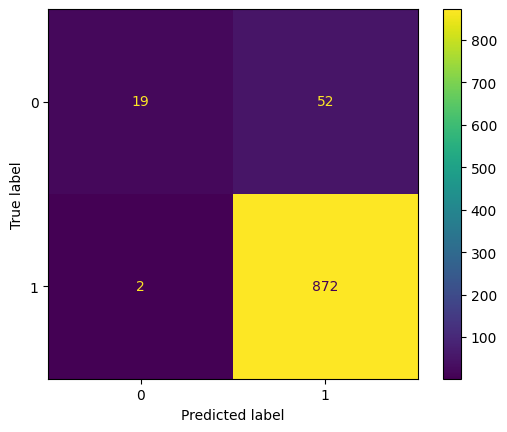

In [88]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_rf.classes_)
cm_display.plot()
plt.show()

### Observation

### Confusion Matrix for Positive and Negative Feedback

| Actual/Predicted   | Predicted Negative | Predicted Positive |
|--------------------|---------------------|--------------------|
| Actual Negative    | 19 (True Negative)  | 52 (False Positive) |
| Actual Positive    | 2 (False Negative) | 872 (True Positive)  |


#### K fold cross-validation

K-fold cross-validation is a technique used in machine learning to assess the performance of a model more reliably than simple train-test splits. It involves splitting the dataset into K subsets (folds) of approximately equal size.



<b>Advantages of K-fold Cross-Validation: </b>

<b>Better Performance Estimate:</b> Provides a more accurate estimate of model performance compared to a single train-test split because it uses multiple splits of the data.

<b>Reduces Bias:</b> Helps in reducing the bias that may result from a specific train-test split.

<b>Maximizes Data Usage:</b> Utilizes all data points in both training and validation phases across K iterations, ensuring that each data point is used for both training and validation.

In [93]:
# using 10 folds
accuracies = cross_val_score(estimator = model_rf, X = X_train_scl, y = y_train, cv = 10)

print(f"Accuracy : {accuracies.mean():.2f}")

#It indicates how much the values deviate from the mean of the dataset.
print(f"Standard Variance : {accuracies.std():.2f}")

Accuracy : 0.93
Standard Variance : 0.01


#### Applying grid search to get the optimal parameters on random forest

<b>Grid search </b>is a method used to find the best combination of hyperparameters for a machine learning model.

<b>Optimal Hyperparameters:</b> After running the grid search, you will get the best combination of hyperparameters from the grid specified. <br>
<b>Cross-Validation Scores:</b> You'll receive both training and validation scores to evaluate model performance.




#### Random Forest Hyperparameters: `max_depth` and `bootstrap`

##### 1. `max_depth`

The `max_depth` parameter sets the maximum depth of each tree in the forest. It controls how deep the tree can grow. Here’s how it works:

- **max_depth = 3**: The tree can only grow to a depth of 3 levels.

##### Example Tree with max_depth = 3

1. **Root Node (Depth 0)**:
   - The root node is at depth 0.

            [Root]
             /   \
       Split 1   Split 2


2. **First Level (Depth 1)**:
   - The nodes resulting from the first split are at depth 1.

            [Root]
             /   \
       [Node1]   [Node2]
         /  \      /  \
   Split 3 Split 4 Split 5 Split 6

3. **Second Level (Depth 2)**:
   - Nodes from the second split are at depth 2.

            [Root]
             /   \
       [Node1]   [Node2]
         /  \      /  \
   [N3] [N4] [N5] [N6]
     / \       / \     / \    / \
    ...       ...    ...   ...

4. **Third Level (Depth 3)**:
   - Nodes at this level are leaf nodes as the maximum depth is reached.

            [Root]
             /   \
       [Node1]   [Node2]
         /  \      /  \
   [N3] [N4] [N5] [N6]
     / \       / \     / \    / \
  [L1] [L2] [L3] [L4] [L5] [L6]

**Note**: No further splits are allowed beyond depth 3.

##### 2. `bootstrap`

The `bootstrap` parameter determines whether bootstrap samples are used when building trees. Bootstrapping means sampling with replacement. This creates multiple different datasets from the original dataset.

##### Example of Bootstrapping

1. **Original Dataset**:
   - Contains 5 samples.

Original Dataset: [S1, S2, S3, S4, S5] <br>


2. **Bootstrap Sample 1**:
   - Samples with replacement, so some samples might appear multiple times.

Bootstrap Sample 1: [S1, S2, S2, S4, S5] <br>


3. **Bootstrap Sample 2**:
   - Another sample with replacement.

Bootstrap Sample 2: [S1, S1, S3, S4, S4] <br>


4. **Multiple Trees with Bootstrap Samples**:
   - Different bootstrap samples create diverse trees.

  Tree 1          Tree 2          Tree 3
[S1, S2, S2,     [S1, S1, S3,    [S2, S3, S4, 
 S4, S5]         S4, S4]         S4, S5]

/   \            /   \            /   \
[Node1][Node2] [Node3][Node4] [Node5][Node6]
/ \ / \ /
[Leaf][Leaf] [Leaf][Leaf] [Leaf][Leaf]



##### Summary of Visual Representations

- **max_depth**:
  - Controls how deep each tree can grow.
  - Example: A tree with `max_depth = 3` will have a maximum of 3 levels.

- **bootstrap**:
  - Creates different datasets by sampling with replacement from the original data.
  - Example: Different trees in the forest are built on different bootstrap samples, ensuring diversity.

#### 3. **min_sampling_split**:
- Initial Node:
Suppose the root node has 50 samples.
Since 50 is greater than 8, the node is eligible for splitting.
csharp

                [50 samples]
                   /    \
              Split based on feature
                 /         \
          [25 samples]   [25 samples]
- Second Level:
Each child node now has 25 samples.
Both nodes are eligible for further splitting because each has more than 8 samples.


              [50 samples]
                 /    \
       [25 samples] [25 samples]
          /   \            /   \
   Split        Split      Split  Split
     / \        / \        / \    / \
[12] [13]   [13] [12]  [14] [11] [15] [10]

- Third Level:
Nodes can continue to split as long as they have more than 8 samples.

              [50 samples]
                 /    \
       [25 samples] [25 samples]
          /   \            /   \
   Split        Split      Split  Split
     / \        / \        / \    / \
[12] [13]   [13] [12]  [14] [11] [15] [10]
- Non-Eligible Node:
If a node has fewer than 8 samples, it becomes a leaf node and does not split further.

              [50 samples]
                 /    \
       [25 samples] [25 samples]
          /   \            /   \
   Split        Split      Split  Leaf
     / \        / \        / \
[12] [13]   [13] [12]  [14] [7]   (no split as < 8)

- Summary
min_samples_split ensures that nodes must have at least the specified number of samples to be eligible for further splitting.







In [94]:
params = {
    'bootstrap': [True], #helps in creating diverse trees, Creates different datasets by sampling with replacement from the original data.
    'max_depth': [80, 100], #Controlling the depth of the tree helps in preventing overfitting (too complex models) or underfitting (too simple models).
    'min_samples_split': [8, 12], #A node must have at least 8 samples to be eligible for splitting. If a node has fewer than 8 samples, it becomes a leaf node and does not split further.
    'n_estimators': [100, 300] #number of trees in the forest.
}

In [95]:
cv_object = StratifiedKFold(n_splits = 2)

grid_search = GridSearchCV(estimator = model_rf, param_grid = params, cv = cv_object, verbose = 0, return_train_score = True)
grid_search.fit(X_train_scl, y_train.ravel())

GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True], 'max_depth': [80, 100],
                         'min_samples_split': [8, 12],
                         'n_estimators': [100, 300]},
             return_train_score=True)

In [96]:
#Getting the best parameters from the grid search


print("Best Parameter Combination : {}".format(grid_search.best_params_))

Best Parameter Combination : {'bootstrap': True, 'max_depth': 80, 'min_samples_split': 8, 'n_estimators': 300}


In [97]:
print("Cross validation mean accuracy on train set : {}".format(grid_search.cv_results_['mean_train_score'].mean()*100)) #accracy of the model tarined in multiple folds of the training data
print("Cross validation mean accuracy on test set : {}".format(grid_search.cv_results_['mean_test_score'].mean()*100)) #Average accuracy of the model on the validation data (not used for training) across all cross-validation folds
print("Accuracy score for test set :", accuracy_score(y_test, y_preds)) #Accuracy of the model on a completely new and unseen test dataset

Cross validation mean accuracy on train set : 97.23230490018149
Cross validation mean accuracy on test set : 91.78765880217784
Accuracy score for test set : 0.9428571428571428


### XgBoost

In [98]:
model_xgb = XGBClassifier()
model_xgb.fit(X_train_scl, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [99]:
#Accuracy of the model on training and testing data
 
print("Training Accuracy :", model_xgb.score(X_train_scl, y_train))
print("Testing Accuracy :", model_xgb.score(X_test_scl, y_test))

Training Accuracy : 0.9723230490018149
Testing Accuracy : 0.9354497354497354


In [100]:
y_preds = model_xgb.predict(X_test)

In [101]:
#Confusion_matrix

cm = confusion_matrix(y_test,y_preds)
print(cm)

[[ 23  48]
 [ 18 856]]


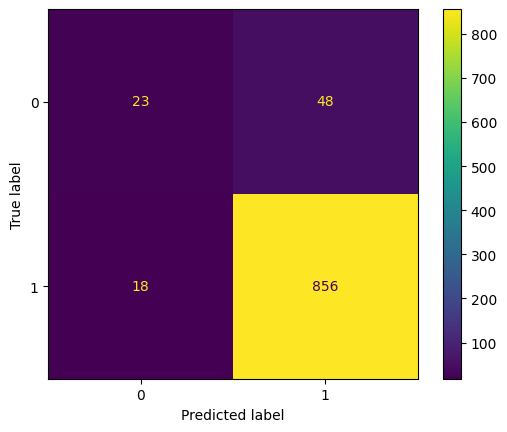

In [102]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_xgb.classes_)
cm_display.plot()
plt.show()

In [103]:
#Saving the XGBoost classifier
pickle.dump(model_xgb, open('Models/model_xgb.pkl', 'wb'))

### Decision Tree Classifier

In [104]:
model_dt = DecisionTreeClassifier()
model_dt.fit(X_train_scl,y_train)

DecisionTreeClassifier()

In [105]:
#Accuracy of the model on training and testing data

print("Training Accuracy : ", model_dt.score(X_train_scl,y_train))
print("Testing Accuracy : " , model_dt.score(X_test_scl,y_test))

Training Accuracy :  0.9941016333938294
Testing Accuracy :  0.9153439153439153


In [106]:
y_preds = model_dt.predict(X_test)

In [107]:
#confusion matrix

cm = confusion_matrix(y_test,y_preds)
print(cm)

[[ 35  36]
 [ 63 811]]


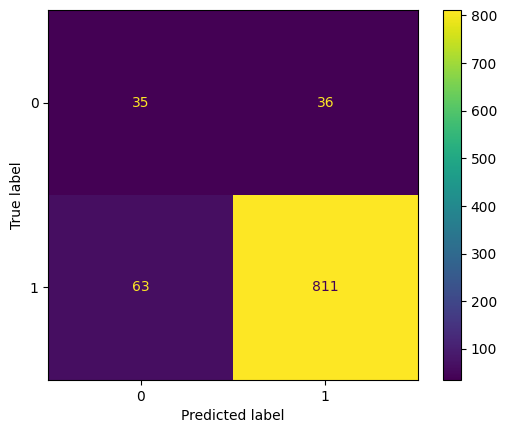

In [108]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_dt.classes_)
cm_display.plot()
plt.show()

### Random forest classifier

- ***Training Accuracy*** : 0.9941016333938294
- ***Testing Accuracy*** : 0.9428571428571428

minute overfitting 

#### After k fold cross validation

Cross validation mean accuracy on train set : 97.23230490018149 <br>
Cross validation mean accuracy on test set : 91.78765880217784 <br>
Accuracy score for test set : 0.9428571428571428

### XgBoost

- ***Training Accuracy*** : 0.9723230490018149
- ***Testing Accuracy*** : 0.9354497354497354

Here training and test accuracy are almost close together better performace comaring to  Random forest


### Decision tree classifier

- ***Training Accuracy*** :  0.9941016333938294
- ***Testing Accuracy*** :  0.9153439153439153

Overfitting training acurray is more



